In [1]:
import torch
import torch.nn.functional as F

torch.manual_seed(0)

# tiny config
BATCH = 256
IN_DIM = 28 * 28
H = 64
OUT_DIM = 10

# one mini‑batch of MNIST
from torchvision import datasets, transforms
ds = datasets.MNIST("data", train=True, download=True,
                    transform=transforms.Compose([transforms.ToTensor()]))
x0, y0 = next(iter(torch.utils.data.DataLoader(ds, batch_size=BATCH, shuffle=False)))
x0 = x0.view(BATCH, -1)          # flatten
y0_onehot = F.one_hot(y0, OUT_DIM).float()


100%|██████████| 9.91M/9.91M [00:00<00:00, 29.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 735kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 6.87MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.65MB/s]


In [2]:
# init weights
W1 = torch.randn(IN_DIM, H, dtype=torch.float32) * 0.01
b1 = torch.zeros(H)
W2 = torch.randn(H, OUT_DIM) * 0.01
b2 = torch.zeros(OUT_DIM)

def forward_manual(x):
    z1 = x @ W1 + b1
    a1 = torch.relu(z1)
    logits = a1 @ W2 + b2
    probs = torch.softmax(logits, dim=1)
    loss = -(y0_onehot * probs.log()).sum(dim=1).mean()
    return loss, (x, z1, a1, logits, probs)

loss, cache = forward_manual(x0)
print("Initial manual loss:", loss.item())


Initial manual loss: 2.302769184112549


In [3]:
def backward_manual(cache):
    x, z1, a1, logits, probs = cache

    # grad of loss w.r.t logits
    dlogits = (probs - y0_onehot) / BATCH           # (B,10)

    # W2 and b2
    dW2 = a1.T @ dlogits                            # (H,10)
    db2 = dlogits.sum(0)

    # back into hidden layer
    da1 = dlogits @ W2.T                            # (B,H)
    dz1 = da1.clone()
    dz1[z1 <= 0] = 0                                # ReLU derivative

    # W1 and b1
    dW1 = x.T @ dz1                                 # (784,H)
    db1 = dz1.sum(0)

    return dW1, db1, dW2, db2


In [4]:
# build the same net in PyTorch autograd
x0_t = x0.detach().clone().requires_grad_(True)
model = torch.nn.Sequential(
    torch.nn.Linear(IN_DIM, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, OUT_DIM),
)
with torch.no_grad():
    model[0].weight.copy_(W1.T)
    model[0].bias.copy_(b1)
    model[2].weight.copy_(W2.T)
    model[2].bias.copy_(b2)

loss_t = F.cross_entropy(model(x0_t), y0)
loss_t.backward()

dW1_a = model[0].weight.grad.T        # transpose to align shapes
db1_a = model[0].bias.grad
dW2_a = model[2].weight.grad.T
db2_a = model[2].bias.grad

dW1_m, db1_m, dW2_m, db2_m = backward_manual(cache)

for name, m, a in [
    ("W1", dW1_m, dW1_a),
    ("b1", db1_m, db1_a),
    ("W2", dW2_m, dW2_a),
    ("b2", db2_m, db2_a),
]:
    diff = (m - a).norm() / a.norm()
    print(f"{name} relative diff {diff:.2e}")


W1 relative diff 8.49e-08
b1 relative diff 9.75e-08
W2 relative diff 7.95e-08
b2 relative diff 1.12e-07


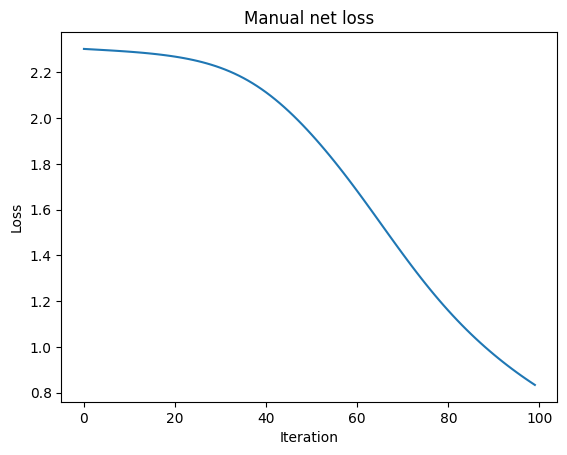

In [5]:
losses = []
for i in range(100):
    loss, cache = forward_manual(x0)
    dW1, db1, dW2, db2 = backward_manual(cache)
    # SGD step
    W1 -= 0.1 * dW1
    b1 -= 0.1 * db1
    W2 -= 0.1 * dW2
    b2 -= 0.1 * db2
    losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Manual net loss")
plt.savefig("manual_loss.png", dpi=120)
